In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2022 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Laura Murgatroyd (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)
#                   Mariam Demir (UKRI-STFC)

# Exercise 02 - Preprocessing with the Core Imaging Library (CIL) 

### 3D laboratory micro-CT, cone-beam data of sunflower seeds in an acrylic box

This exercise walks through the steps needed to load in a 3D cone-beam dataset of sunflower seeds in an acrylic box, acquired by laboratory micro-CT, pre-process, and reconstruct it using FDK.

Notice, this uses the same sample as in [01_intro_seeds_conebeam.ipynb](./01_intro_seeds_conebeam.ipynb). However, in that notebook, the dataset file we used had already been altered to contain the centre of rotation offset. Here we use a file which has not had that applied, so we need to establish the centre of rotation offset ourselves, using CIL.

Learning objectives are:
- Load and investigate a Nikon data set.
- Apply CIL's `TransmissionAbsorptionConverter`.
- Apply CIL's Centre of Rotation corrector.
- Compute FDK reconstruction using CIL.
- Re-bin a dataset using CIL's `Binner` processor.

This example requires the dataset `korn.zip` from https://zenodo.org/record/6874123#.Y0ghJUzMKUm :

- https://zenodo.org/record/6874123/files/korn.zip

If running locally please download the data and update the filepath in the `filename` variable below:

In [3]:
filename = "/mnt/share/materials/SIRF/Fully3D/CIL/Korn i kasse/47209 testscan korn01.xtekct"

In [4]:
import os
from cil.io import NikonDataReader
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector, Binner
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

Here we turn on logging for CIL's processors. This means we will get more detailed information when running the processors. This is especially useful when calculating the centre of rotation offset.

In [5]:
import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

## Exercise A: Loading Nikon Data and looking at the Geometry

1. Load the 3D cone-beam projection data of the seeds, using the `NikonDataReader`
2. `print` the data to get some basic information.
3. As well as the data itself, AcquisitionData contains geometric metadata in an AcquisitionGeometry object in the geometry field. `print` the geometry data.
4. Use the `show_geometry` method to display the scan set up visually.

*Note: This is a full 3D dataset so reading it from disk may take some time*

The data is loaded in as a CIL `AcquisitionData` object. How many projections does this dataset contain and how many pixels do they have? Make sure to check the axis labels.

**Uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time**

Number of dimensions: 3
Shape: (1571, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -261.30649948,    0.        ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.        , 850.41650052,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-9 in degrees: [180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762]
	Angles 1561-1570 in degrees: [-177.70847, -177.93762, -178.16678, -178.39594, -178.62509, -178.85425,
 -179.08337, -179.31253, -179.54169, -17

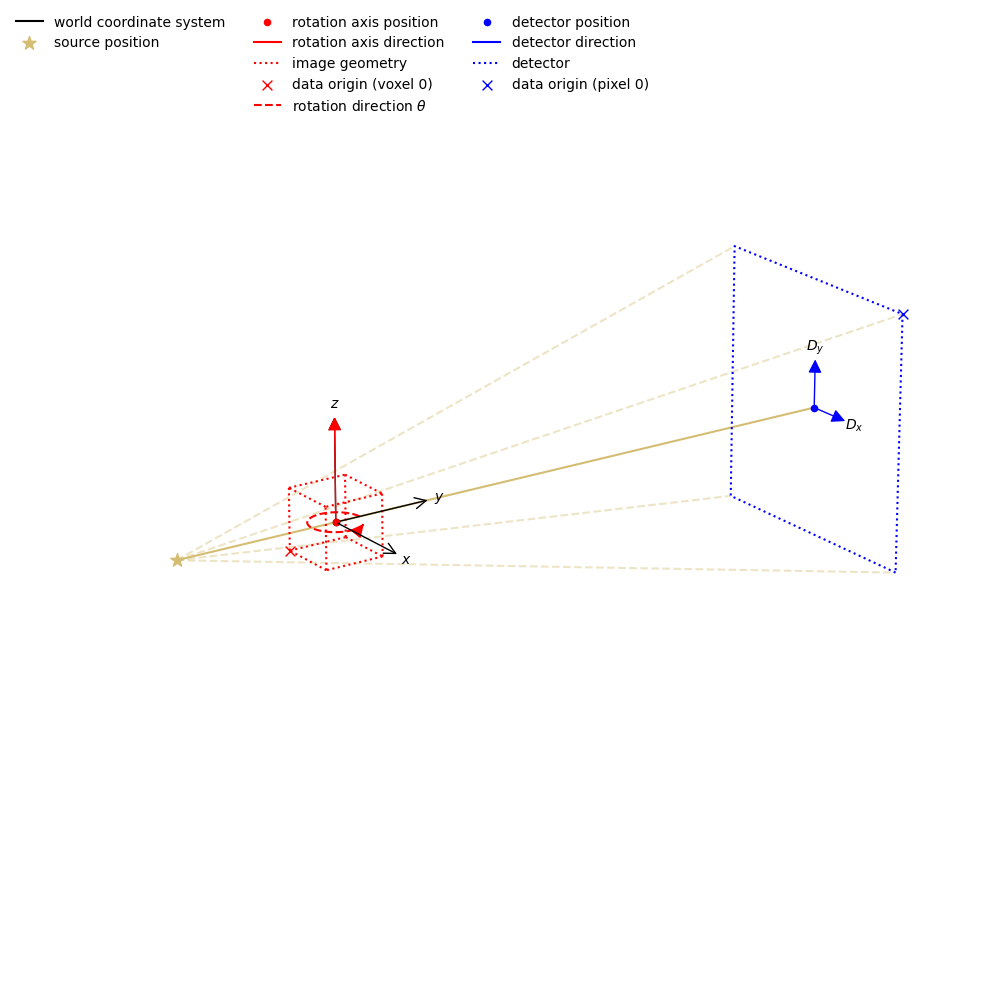

In [6]:
# read in the data from the Nikon `xtekct` file
data_in = NikonDataReader(file_name=filename).read()

# print the meta data associated with the data
print(data_in)

# print the geometry data associated with the data
print(data_in.geometry)

# display the geometry
show_geometry(data_in.geometry)

# We can see that this dataset contains 1571 projections each size 1000x1000 pixels.

## Exercise B: Displaying the Projections with islicer

Use `islicer` to display the projections.

Uncomment the following line to see the solution:

In [7]:
islicer(data_in, direction='angle',size=10, origin='upper')

## Exercise C: Transmission to Absorption Conversion

You should have seen that the data is transmission data. We know this because the background value is 1.0. We need to apply the Beer–Lambert law to convert to the absorption data.

1. Use CIL's Transmission to Absorption processor to convert the data to absorption.
2. Use show2D to look at the central `vertical` slice of the absorption data

Uncomment the following line to see the solution:

INFO:cil.processors.TransmissionAbsorptionConverter:
 Current min_intensity = 0.0: output may contain NaN or inf. Ensure your data only contains positive values or set min_intensity to a small positive value.


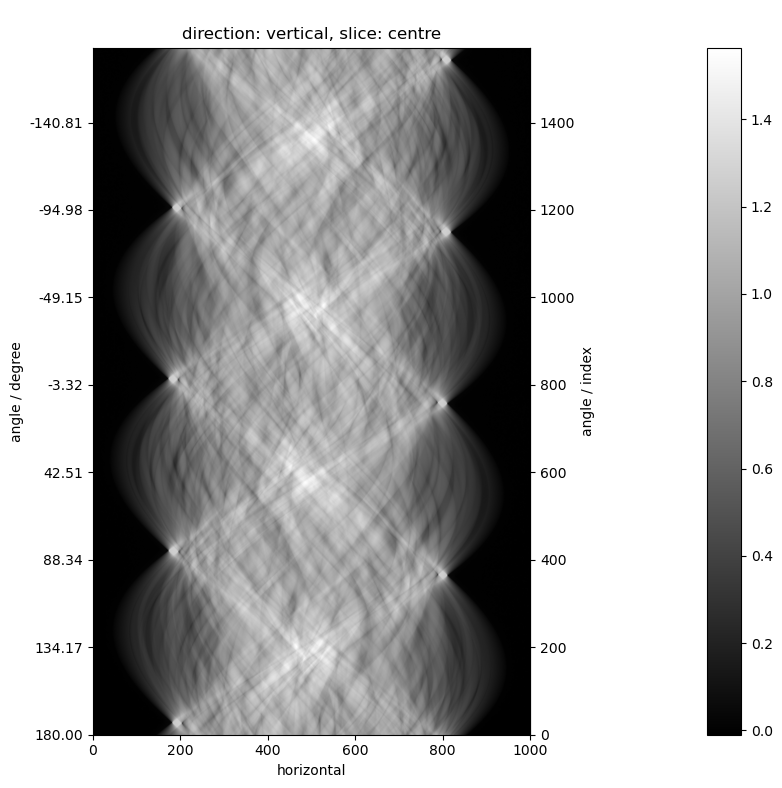

In [8]:
# calculate the absortion data using the Beer–Lambert law
data_absorption = TransmissionAbsorptionConverter()(data_in)

# show the centre slice using show2D
show2D(data_absorption, slice_list=('vertical', 'centre'))

## Exercise D: Reconstructing with FDK

We will use the `FDK` algorithm from CIL's recon module. FDK is filtered back-projection with special weights for cone-beam data. By default, the `recon` module uses TIGRE as a back-end. We will use 

1. Use reorder to ensure the data is in the correct format for tigre
2. Create and run the `FDK` algorithm, using our `image_geometry` created below.
3. Then show the reconstructed volume using `islicer`.

In [9]:
image_geometry = data_absorption.geometry.get_ImageGeometry()
image_geometry.voxel_num_x = 700
image_geometry.voxel_num_y = 700
image_geometry.voxel_num_z = 700

Uncomment the following line to see the solution:

In [10]:
# reorder the data for the `tigre` backend
data_absorption.reorder(order='tigre')

# create the FDK reconstructor
fdk =  FDK(data_absorption, image_geometry)

# run the reconstructor
recon = fdk.run()

# visualise the 3D reconstructed volume
islicer(recon, direction='vertical', size=10) # change to 'horizontal_y' or 'horizontal_x' to view the data in other directions

FDK recon

Input Data:
	angle: 1571
	vertical: 1000
	horizontal: 1000

Reconstruction Volume:
	vertical: 700
	horizontal_y: 700
	horizontal_x: 700

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



## Exercise E: Performing Centre of Rotation Correction

You should notice that the above reconstruction does not look right. This edge-doubling is a classic artifact from a centre of rotation offset. 

In a perfectly aligned CT system the projection of the axis of rotation onto the detector is aligned with the horizontal centre of the detector. In practise it is not usually perfectly aligned. A slight offset of the centre of rotation with respect to the theoretical position used in the reconstruction will contribute to the loss of resolution; in more severe cases it will cause the severe artifacts in the reconstructed volume we see above.

We can estimate the true centre of rotation offset from the acquisition data using CIL's `CentreOfRotationCorrector`. Here we will use CIL's the `image_sharpness` algorithm as it works well on cone-beam data.

1. Use CIL to calculate and apply the centre of rotation correction and find out how many pixels offset it calculated
2. Use `show_geometry` and `print` to compare the geometry before and after the correction.

Uncomment the following line to see the solution:

INFO:cil.processors.CofR_image_sharpness:evaluated 11 points
INFO:cil.processors.CofR_image_sharpness:Centre of rotation correction found using image_sharpness
INFO:cil.processors.CofR_image_sharpness:backend FBP/FDK tigre
INFO:cil.processors.CofR_image_sharpness:Calculated from slice: centre
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 4.798980 pixels
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 0.451193 units at the object
INFO:cil.processors.CofR_image_sharpness:Return new dataset with centred geometry


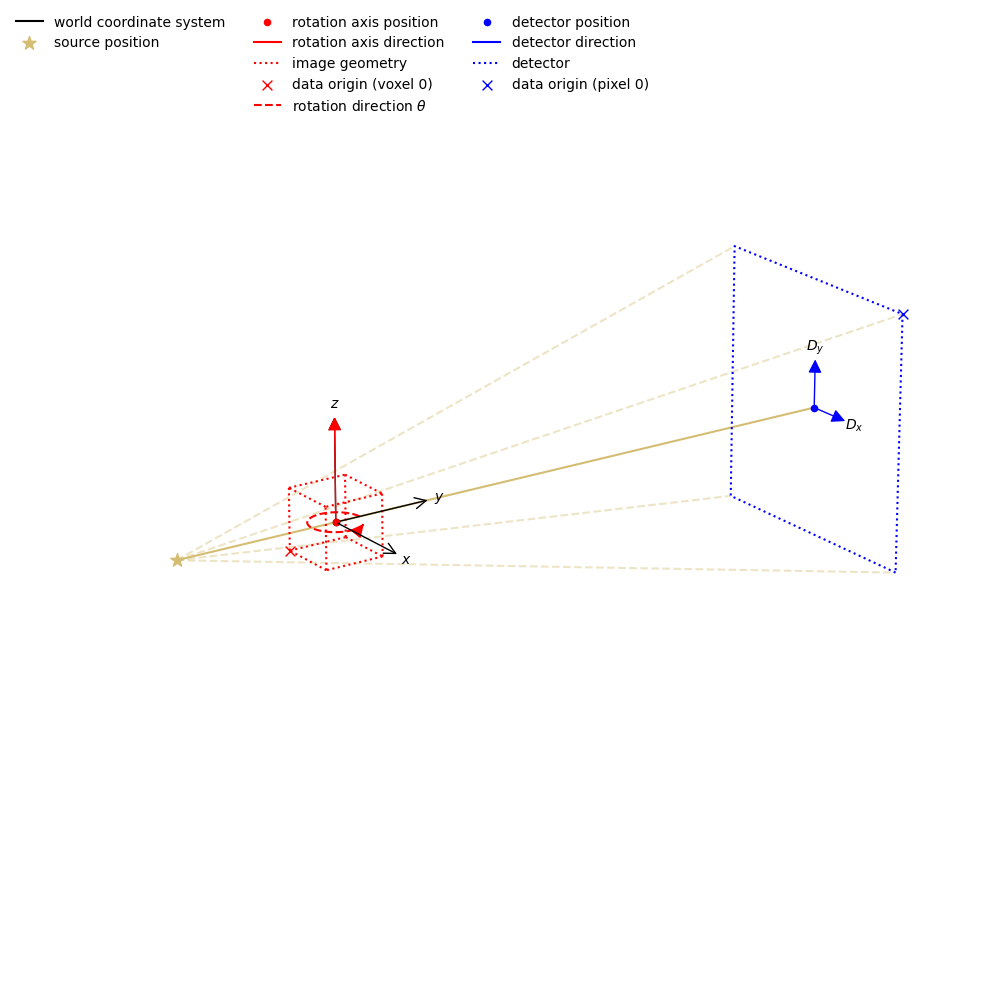

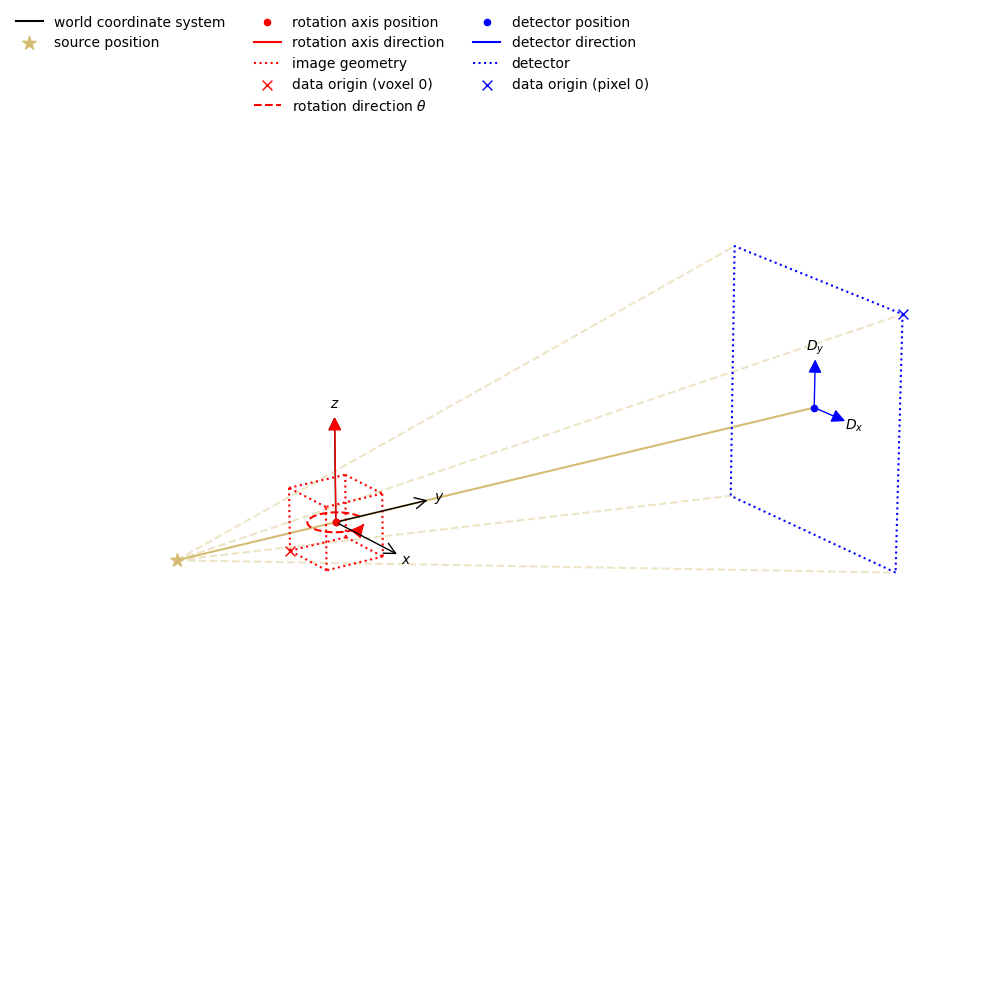

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -261.30649948,    0.        ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.        , 850.41650052,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-9 in degrees: [180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762]
	Angles 1561-1570 in degrees: [-177.70847, -177.93762, -178.16678, -178.39594, -178.62509, -178.85425,
 -179.08337, -179.31253, -179.54169, -179.77084]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
3D Cone-beam tomography
System configuration:
	Source position: [   0.        , 

In [11]:
#Run `image_sharpness` on the dataset and return a new dataset with a new geometry.
data_centred = CentreOfRotationCorrector.image_sharpness(backend='tigre', search_range=100, tolerance=0.1)(data_absorption)
# From the logging, we can see that the centre of rotation offset is 4.8 pixels. Therefore it isn't noticeable when we use show_geometry.

#show the original geometry
show_geometry(data_absorption.geometry)

#show the centred geometry
show_geometry(data_centred.geometry)

#print the original geometry
print(data_absorption.geometry)

#print the new geometry
print(data_centred.geometry)

## Exercise F: Reconstruct the Centre of Rotation Corrected Data


Now that we have applied the centre of rotation correction, perform the FDK reconstruction:

Uncomment the following line to see the solution:

In [12]:
# reorder the data for the `tigre` backend
data_centred.reorder(order='tigre')

# create the FDK reconstructor
fdk =  FDK(data_centred, image_geometry)

# run the reconstructor
recon = fdk.run()

# visualise the 3D reconstructed volume
islicer(recon, direction='vertical', size=10) # change to 'horizontal_y' or 'horizontal_x' to view the data in other directions

FDK recon

Input Data:
	angle: 1571
	vertical: 1000
	horizontal: 1000

Reconstruction Volume:
	vertical: 700
	horizontal_y: 700
	horizontal_x: 700

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



## Exercise G: Binning Data

Start again from using the dataset we read from the file (before we applied any processing).
Re-bin the data 4x along both the horizontal and vertical axes.
Refer to the [CIL documentation](https://tomographicimaging.github.io/CIL/nightly/processors/#data-binner) for how to set up the `Binner` processor.

Then process (transmission to absorption convert and centre of rotation correct) the binned data and reconstruct with FDK:



Uncomment the following line to see the solution:

New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -261.30649948,    0.        ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 850.41650052,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [250 250]
	Pixel size: [1.6 1.6]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-9 in degrees: [180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762]
	Angles 1561-1570 in degrees: [-177.70847, -177.93762, -178.16678, -178.39594, -178.62509, -178.85425,
 -179.08337, -179.31253, -179.54169, -179.77084]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (1571, 250, 250)
New geometry shape:  (1571, 250, 250)


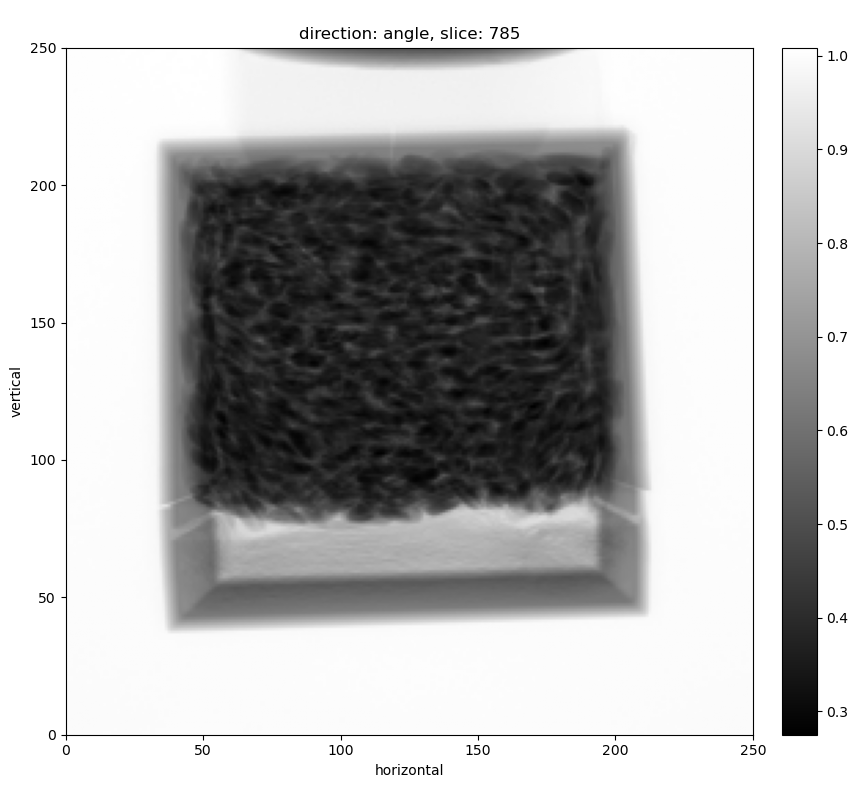

INFO:cil.processors.TransmissionAbsorptionConverter:
 Current min_intensity = 0.0: output may contain NaN or inf. Ensure your data only contains positive values or set min_intensity to a small positive value.
INFO:cil.processors.CofR_image_sharpness:evaluated 17 points
INFO:cil.processors.CofR_image_sharpness:Centre of rotation correction found using image_sharpness
INFO:cil.processors.CofR_image_sharpness:backend FBP/FDK tigre
INFO:cil.processors.CofR_image_sharpness:Calculated from slice: centre
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 1.197561 pixels
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 0.450372 units at the object
INFO:cil.processors.CofR_image_sharpness:Return new dataset with centred geometry


FDK recon

Input Data:
	angle: 1571
	vertical: 250
	horizontal: 250

Reconstruction Volume:
	vertical: 250
	horizontal_y: 250
	horizontal_x: 250

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False



In [13]:
data_binned = Binner(roi={'horizontal': (None, None, 4), 'vertical': (None, None, 4)})(data_in)
show2D(data_binned)

data_binned_absorption = TransmissionAbsorptionConverter()(data_binned)

data_binned_centred = CentreOfRotationCorrector.image_sharpness()(data_binned_absorption)
# notice the offset is approximately the same in mm as calculated on the un-binned data, but the offset in pixels is now 1/4 of the value


data_binned_centred.reorder(order='tigre')
fdk =  FDK(data_binned_centred)
recon = fdk.run()
islicer(recon, direction='vertical', size=10) # change to 'horizontal_y' or 'horizontal_x' to view the data in other directions